In [1]:
import awkward as ak

In [2]:
import numpy as np

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.basemap

In [4]:
import sklearn.neighbors

In [5]:
argo = ak.from_parquet("~/storage/data/argo-floats/argo-floats", lazy=True)
# argo = ak.from_parquet("~/storage/data/argo-floats/argo-floats/ocean=pacific/year=2020/argo-pacific-2020.parquet", lazy=True)
# argo

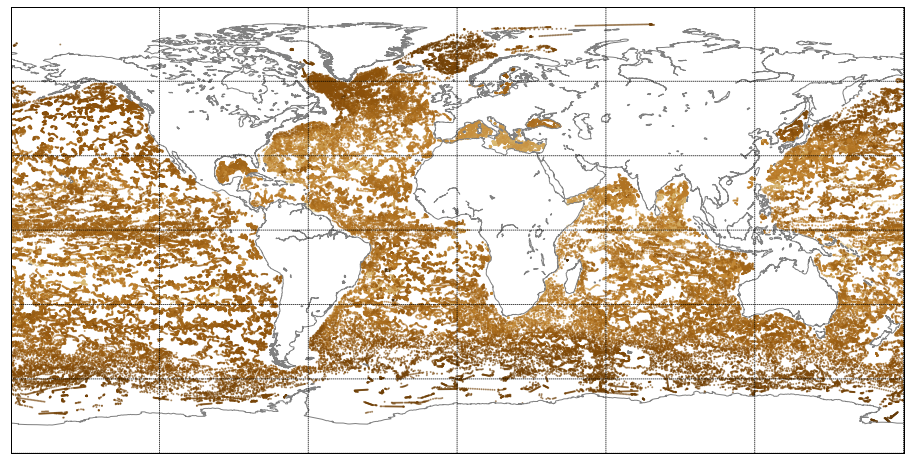

In [7]:
# cut = (25567 < argo.profiles.juld) & (argo.profiles.juld < 25933)  # 2020
cut = argo.year == "2020"

temperature = ak.mean(argo.profiles.levels.temp[cut], axis=2)
has_temperature = ~ak.is_none(temperature, axis=1)

longitude = np.asarray(ak.flatten(argo.profiles.longitude[cut][has_temperature]))
latitude = np.asarray(ak.flatten(argo.profiles.latitude[cut][has_temperature]))
temperature = np.asarray(ak.flatten(ak.fill_none(temperature[has_temperature], -9999)))   # https://github.com/scikit-hep/awkward-1.0/issues/490

fig = plt.figure(figsize=(16, 16))
basemap = mpl_toolkits.basemap.Basemap(projection="cyl", lon_0=0, resolution="l")
basemap.drawcoastlines(color="gray")
basemap.drawparallels(np.arange(-90, 120, 30))
basemap.drawmeridians(np.arange(0., 420, 60))
basemap.drawmapboundary()
plt.scatter(longitude, latitude, s=1, c=temperature, cmap="BrBG", alpha=0.5)

In [108]:
position_as_index = np.trunc((longitude + 180) * 1000 / 360).astype(np.int64) + 1000 * np.trunc((latitude + 90) * 1000 / 180).astype(np.int64)

In [109]:
numerator = np.zeros(1000 * 1000)
denominator = np.zeros(1000 * 1000)

np.add.at(numerator, position_as_index, temperature)
np.add.at(denominator, position_as_index, 1)

In [110]:
rasterized = np.true_divide(numerator, denominator, where=(denominator != 0)).reshape(1000, 1000)

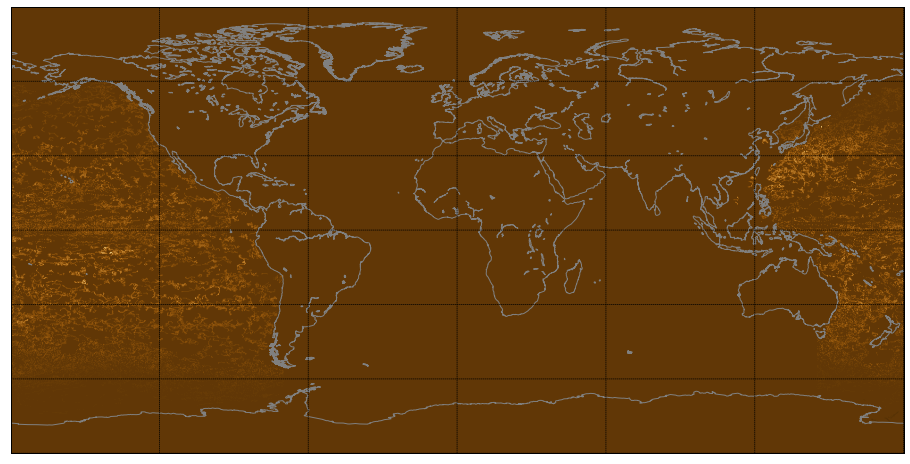

In [111]:
fig = plt.figure(figsize=(16, 16))
basemap = mpl_toolkits.basemap.Basemap(projection="cyl", lon_0=0, resolution="l")
basemap.drawcoastlines(color="gray")
basemap.drawparallels(np.arange(-90, 120, 30))
basemap.drawmeridians(np.arange(0., 420, 60))
basemap.drawmapboundary()
plt.imshow(rasterized, cmap="BrBG", extent=(-180, 180, -90, 90), origin="lower")

In [159]:
model = sklearn.neighbors.KNeighborsRegressor(radius=5, weights="distance").fit(np.dstack([longitude, latitude])[0], temperature)

In [160]:
xx, yy = np.meshgrid(np.linspace(-180, 180, 1000), np.linspace(-90, 90, 1000))
pairs = np.column_stack((xx.ravel(), yy.ravel()))

In [161]:
rasterized = model.predict(pairs)

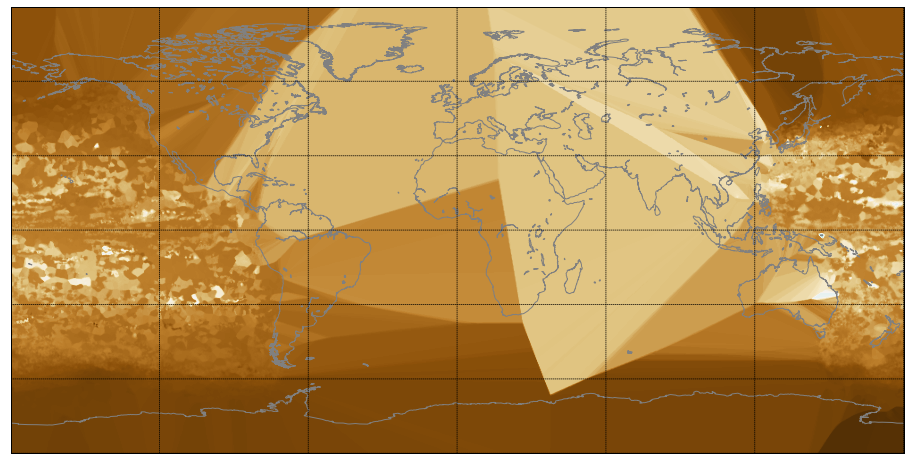

In [162]:
fig = plt.figure(figsize=(16, 16))
basemap = mpl_toolkits.basemap.Basemap(projection="cyl", lon_0=0, resolution="l")
basemap.drawcoastlines(color="gray")
basemap.drawparallels(np.arange(-90, 120, 30))
basemap.drawmeridians(np.arange(0., 420, 60))
basemap.drawmapboundary()
plt.imshow(rasterized.reshape(1000, 1000), cmap="BrBG", extent=(-180, 180, -90, 90), origin="lower")

In [6]:
argo2020 = argo[argo.year == "2020"]

In [80]:
year_profiles = ak.flatten(argo2020.profiles)

In [81]:
sorter = ak.argsort(year_profiles.float_serial_no)

In [82]:
counts = ak.run_lengths(year_profiles.float_serial_no[sorter])

In [83]:
grouped = ak.unflatten(year_profiles[["float_serial_no", "longitude", "latitude"], sorter], counts)

In [84]:
linetos = ak.unflatten(np.full(ak.sum(counts - 1), matplotlib.path.Path.LINETO), counts - 1)

In [85]:
path_codes = ak.concatenate(([[matplotlib.path.Path.MOVETO]], linetos), axis=1)

In [86]:
path_verts = ak.concatenate((grouped.longitude[:, :, np.newaxis], grouped.latitude[:, :, np.newaxis]), axis=2)

In [87]:
region = ((-76.157227 - 40 < grouped.longitude) & (grouped.longitude < -76.157227 + 40) &
          ( 15.326572 - 20 < grouped.latitude)  & (grouped.latitude  <  15.326572 + 20))

(-4.6734279999999995, 35.326572)

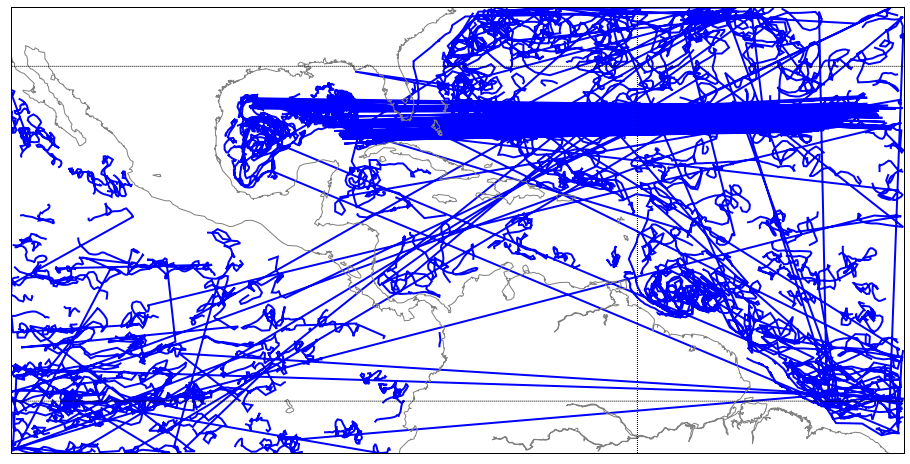

In [93]:
fig, ax = plt.subplots(figsize=(16, 16))
basemap = mpl_toolkits.basemap.Basemap(projection="cyl", lon_0=-76.157227, lat_0=15.326572, resolution="l")
basemap.drawcoastlines(color="gray")
basemap.drawparallels(np.arange(-90, 120, 30))
basemap.drawmeridians(np.arange(0., 420, 60))
basemap.drawmapboundary()

verts = np.asarray(ak.flatten(path_verts[region][:]))
codes = np.asarray(ak.flatten(path_codes[region][:]))

path = matplotlib.path.Path(verts, codes)
patch = matplotlib.patches.PathPatch(path, facecolor="None", lw=2, edgecolor="blue")
ax.add_patch(patch)
ax.set_xlim([-76.157227 - 40, -76.157227 + 40])
ax.set_ylim([ 15.326572 - 20,  15.326572 + 20])